In [366]:
import pandas as pd
import numpy as np

In [367]:
#create mock data

from sklearn.datasets import make_regression
feat, target = make_regression(100, 10)

#from sklearn.datasets import make_classification
#features_clas, target_clas = make_classification(100, 10)

#from sklearn.datasets import load_iris
#data = load_iris()

# Linear Regression

### Sklearn model

In [368]:
from sklearn.linear_model import LinearRegression

In [369]:
model = LinearRegression()
model.fit(feat, target)
print(model.coef_)
print(model.intercept_)

[10.96454661 59.90266759 47.66915751 63.19395526 67.94840619 67.90248973
 65.4341358  52.00820883 92.56368972 36.64200331]
4.440892098500626e-14


### Сalculation of weights according to the minimization formula
(ordinary least squares)

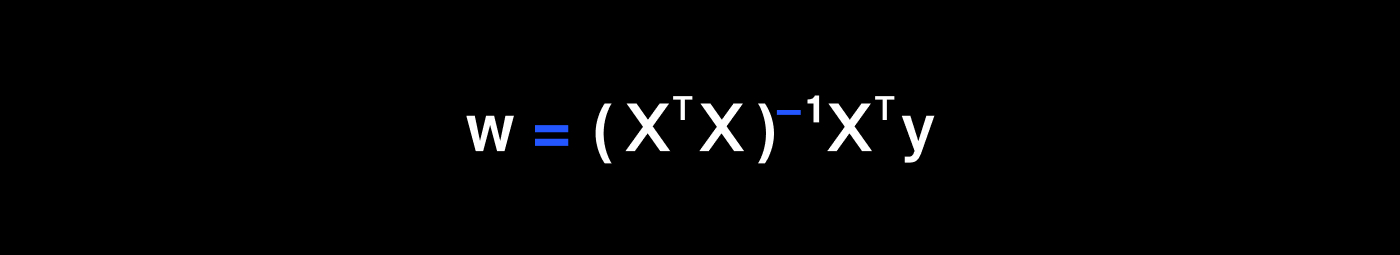

In [370]:
class LinearRegressionSelf:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        #addind a column with '1' for interception calculation (coef = 1)
        y = train_target
        w = np.linalg.inv(X.T@X)@(X.T)@y #np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) 
        self.w = w[1:]
        self.w0 = w[0]
    def predict(self, test_features):
        return test_features@(self.w) + self.w0
    
model = LinearRegressionSelf()
model.fit(feat, target)

print(model.w)
print(model.w0)

[10.96454661 59.90266759 47.66915751 63.19395526 67.94840619 67.90248973
 65.4341358  52.00820883 92.56368972 36.64200331]
7.549516567451064e-15


### Gradient boosting model

In [371]:
#derivative (y- m1*x1-m2*x2 - m3*x3-b)^2 with respect to m1  (https://www.wolframalpha.com/)

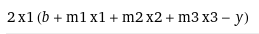

In [372]:
#y_pred = m1*x1+m2*x2+m3*x3+b  -> derivative for m1 = 2*x1*(y_pred-y)

# -derivative for m1 = 2*x1*(y-y_pred)
# -derivative for b = 2*(y-y_pred)

In [373]:
features = pd.DataFrame(feat)
coef = pd.Series(1.00, index=features.columns) # all the regression coefficients =1
b = 1.00 # interception = 1
n=500 #number of iterations
nu=0.01 #learning rate

In [374]:
len_col = len(features.columns)
features['y_pred'] = features@coef+b # make the first prediction

In [375]:
features.head(3)

,0,1,2,3,4,5,6,7,8,9,y_pred
0,1.287873,-0.140504,-0.576457,-0.320381,0.094356,0.468422,-1.644055,-0.367241,-1.435638,-0.276777,-1.910402
1,-1.238857,-0.113082,0.869958,-1.312128,0.220634,0.002883,0.351460,0.294658,-0.301130,-0.344206,-0.569809
2,1.402731,0.254625,1.780878,-2.221433,-0.696911,-0.443712,0.788256,0.760112,0.319051,-0.809530,2.134068


In [376]:
for _ in range(n):
    col_names = []
    for index in range(0, len(coef)):   
        col_name = 'm'+str(coef.index[index])
        col_names.append(col_name)
        features[col_name] = 2*features[index]*(target-features['y_pred']) #calculating gradient for each feature
    b = b+2*nu*(target-features['y_pred']).mean() #adding -gradient to the inderception
    for index, name in enumerate(col_names):
        coef[index] = coef[index]+ nu*features[name].mean() #adding -gradient to the cofficients
    features['y_pred'] = features[features.columns[0:len_col]]@coef+b #making the new prediction
    #print( (abs(target-features['y_pred'])).mean())

In [377]:
features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,1.287873,-0.140504,-0.576457,-0.320381,0.094356,0.468422,-1.644055,-0.367241,-1.435638,-0.276777,...,-0.053087,0.005792,0.023762,0.013206,-0.003889,-0.019309,0.067769,0.015138,0.059178,0.011409
1,-1.238857,-0.113082,0.869958,-1.312128,0.220634,0.002883,0.351460,0.294658,-0.301130,-0.344206,...,0.321037,0.029304,-0.225441,0.340024,-0.057175,-0.000747,-0.091077,-0.076358,0.078035,0.089197
2,1.402731,0.254625,1.780878,-2.221433,-0.696911,-0.443712,0.788256,0.760112,0.319051,-0.809530,...,-0.872533,-0.158383,-1.107750,1.381786,0.433496,0.276000,-0.490315,-0.472809,-0.198458,0.503547


### Сalculating weights using a stochastic gradient descent model + matrix multiplification
Formula of the gradient (array, applying to the weights vector(w))

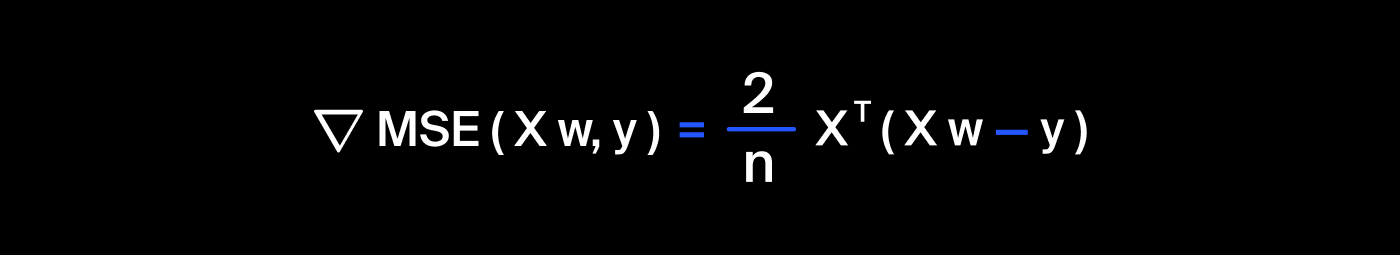

In [381]:
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size):
        self.step_size = step_size #learning rate
        self.epochs = epochs #number of iterations
        self.batch_size = batch_size 
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        #addind a column with '1' for interception calculation (coef = 1)
        y = train_target
        w = np.ones(X.shape[1]) ## all the regression coefficients = 1
        self.batches_count = len(train_features)//self.batch_size 
        for _ in range(self.epochs):
            for i in range(self.batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                gradient = (2/X_batch.shape[0]) *X_batch.T@(X_batch@w-y_batch) 
                # (X_batch@w - y_batch) - array with differences between predictions array and targets array
                # X_batch.T - matrix of x values, rotated to multiply correctly at differencies array
                w -= self.step_size*gradient 
        self.w = w[1:]
        self.w0 = w[0]
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
modelSGD = SGDLinearRegression(0.01, 500, 10)
modelSGD.fit(feat, target)

In [382]:
pd.DataFrame({'SKLearn (MinFor)': model.w, 'coefGB':coef, 'coefSCD': modelSGD.w})

,SKLearn (MinFor),coefGB,coefSCD
0,10.964547,10.996515,10.964547
1,59.902668,59.788813,59.902668
2,47.669158,47.723676,47.669158
3,63.193955,63.214885,63.193955
4,67.948406,67.830453,67.948406
5,67.902490,67.794883,67.902490
6,65.434136,65.612500,65.434136
7,52.008209,51.928122,52.008209
8,92.563690,92.381025,92.563690
9,36.642003,36.592740,36.642003
